# Graf Diekerta - Teoria Współbierzności
Piotr Świerzy

## Zależności

Zależności są napisane w `requirements.txt`. Można je zainstalować automatycznie uruchamiając następujący kod:
```bash
pip install -r requirements.txt
```

Lub:
```bash
pip install networkx matplotlib pydot
```

Wymagane jest też zainstalowanie `Graphviz` z nastepującego [linku](https://graphviz.org/download).

## Kod Rozwiązania

### Importy

Importujemy wymagane biblioteki

In [1]:
import os
import networkx as nx
import matplotlib.pyplot as plt

### Parsowanie danych z pliku

W `filename` mamy path do pliku `.txt`, w którym dane powinny byc przedstawione w następujący sposób:
```
(a) x := x + y
(b) y := y + 2z
(c) x := 3x + z
(d) z := y - z
A = {a,b,c,d}
w = baadcb
```

, gdzie **a, b, c ...** to transakcje na zmiennych, **A** to alfabet, a **w** to słowo.

In [2]:
def read_file(filename):
    with open(filename, "r") as f:
        lines = f.readlines()

    transaction = {}
    alphabet = set()
    word = ""

    for line in lines:
        line = line.strip()

        if line.startswith("A ="):
            letters = line.split("=")[1].strip()[1:-1].split(",")
            for l in letters:
                alphabet.add(l.strip())

        elif line.startswith("w ="):
            word = line.split("=")[1].strip()

    transaction_keys = set()

    for line in lines:
        if line.startswith("("):
            key = line[1]
            if key in alphabet:
                x = line.split(")")[1].split(":=")[0].strip()
                transaction_keys.add(x)

    for line in lines:
        if line.startswith("("):
            key = line[1]
            if key in alphabet:
                expr = line.split(")")[1].split(":=")
                using = set()

                for ch in line.split(")")[1]:
                    if ch in transaction_keys:
                        using.add(ch)
                
                transaction[key] = (expr[0].split()[0], using)

    return alphabet, word, transaction


current_dir = os.getcwd()
filename = os.path.join(current_dir, "data/case3.txt")

alphabet, word, transaction = read_file(filename)

 - `alphabet` to zbiór liter w alfabecie
 - `word` to słowo
 - `transaction` to mapa: `transakcja -> ( zmieniana zmienna, set zmiennych uzywanych )`

Przykładowo:

In [3]:
print("A = ", alphabet)
print("w = ", word)
print("transactions = ", transaction)

A =  {'b', 'a', 'd', 'c'}
w =  baadcb
transactions =  {'a': ('x', {'y', 'x'}), 'b': ('y', {'z', 'y'}), 'c': ('x', {'z', 'x'}), 'd': ('z', {'z', 'y'})}


### Wyznaczanie relacji zależności i niezależności

Dla każdej kombinacji dwóch transakcji z alfabetu patrzymy czy zmieniają wykorzystywane przez tą drugą transakcje zmienne. Jeśli tak to dodajemy tą relacje do zbioru relacji zależnych **D**. Jeśli nie to do zbioru relacji niezależnych **I**.

In [4]:
def create_I_D(alphabet, transaction):
    I = set()
    D = set()

    for a in alphabet:
        for b in alphabet:
            (x, x_set) = transaction[a]
            (y, y_set) = transaction[b]

            if x in y_set or y in x_set:
                D.add((a, b))
            else:
                I.add((a, b))

    return I, D

I, D = create_I_D(alphabet, transaction)

print("I = ", I)
print("D = ", D)

I =  {('b', 'c'), ('c', 'b'), ('a', 'd'), ('d', 'a')}
D =  {('b', 'a'), ('d', 'd'), ('d', 'b'), ('d', 'c'), ('c', 'd'), ('c', 'a'), ('a', 'b'), ('a', 'c'), ('a', 'a'), ('b', 'd'), ('b', 'b'), ('c', 'c')}


### Tworzenie grafu Diekerta

Każdy `Node` grafu posiada:
- `no` - numer w słowie
- `value` - transakcja należąca do alfabetu
- `next` - set kolejnych Node'ów
- `layer` - przydatny przy obliczaniu FNF pokazuje, w której warstwie jest ten Node
- `is_connected` - metoda sprawdza czy dwa node'y są już ze sobą połączone
- `add_next` - metoda dodaje node'a do setu `next` i zmienia jego `layer` za pomocą `update_layer`.

In [5]:
class Node:
    def __init__(self, no, value):
        self.no = no
        self.value = value
        self.next = set()
        self.layer = 0
    
    def is_connected(self, no):
        if self.no >= no: return self.no == no
    
        for node in self.next:
            if node.is_connected(no):
                return True
        
        return False
    
    def add_next(self, node):
        self.next.add(node)
        node.update_layer(self.layer + 1)

    def update_layer(self, n):
        if n > self.layer:
            self.layer = n
            for node in self.next:
                node.update_layer(n+1)

Graf tworzymy następująco:
- dodajemy po kolei wszystkie Node'y w słowie
- zaczynamy od najkrótszych połączeń (od długości 1 do długości słowa minus 1)
- dla każdego możliwego połączenia o danej długości sprawdzamy czy jest możliwa (czy jest w `D`) i czy jest potrzebna (czy nie są już połączone)
- jeśli jest możliwa i potrzebna to dodajemy połączenie

In [6]:
def make_graph(word):

    graph = []
    for i in range(len(word)):
        node = Node(i, word[i])
        graph.append(node)

    for d in range(1, len(word)):
        for i in range(len(word)-d):
            fst_node: Node = graph[i]
            snd_node: Node = graph[i+d]

            if (fst_node.value, snd_node.value) in D:
                if not fst_node.is_connected(snd_node.no):
                    fst_node.add_next(snd_node)
    
    return graph

graph = make_graph(word)

### Rysowanie grafu

Rysowanie grafu skierowanego za pomocą funkcji z bibliotek `networkx` i `pydot`.

W `labels` dodajemy jeszcze `layer`, w którym znajduje się dany `Node`.

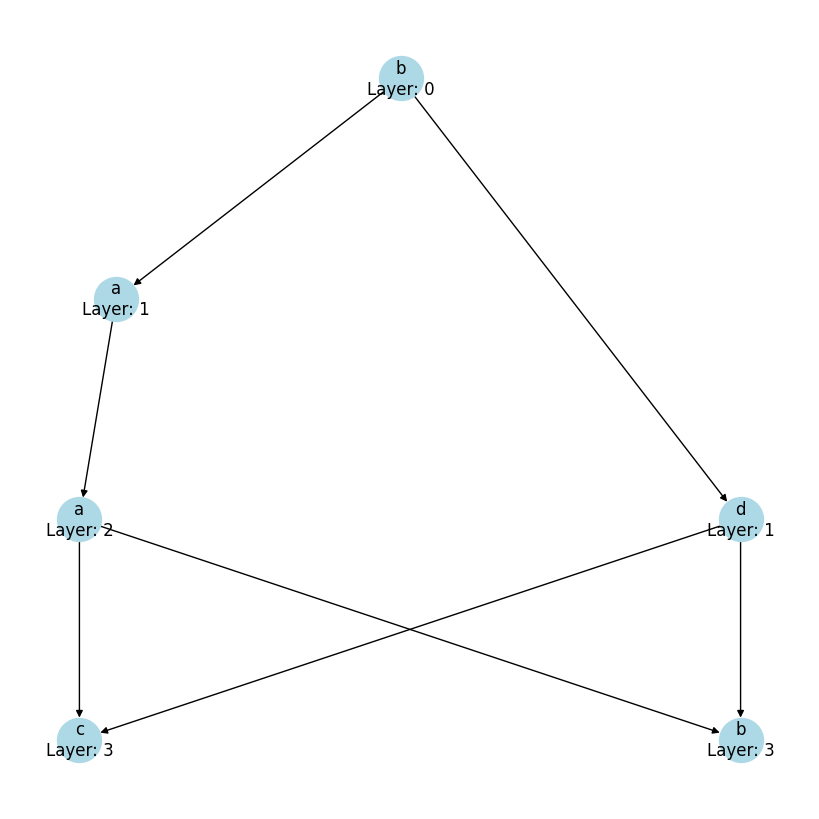

In [7]:
def plot_graph(graph):

    G = nx.DiGraph()

    for node in graph:
        G.add_node(node.no, label=node.value)

    for node in graph:
        for nxt in node.next:
            G.add_edge(node.no, nxt.no)

    pos = nx.nx_pydot.graphviz_layout(G, prog='dot')

    plt.figure(figsize=(8,8))
    nx.draw(G, pos, with_labels=False, node_size=1000, node_color='lightblue')

    labels = {node.no: f"{node.value}\nLayer: {node.layer}" for node in graph}
    nx.draw_networkx_labels(G, pos, labels)
    plt.show()

plot_graph(graph)

### Postać Normalna Foaty (FNF)

Dla każdego `Node'a` w grafie patrzymy na `layer` i przypisujemy go do odpowiedniej warstwy, a na koniec wypisujemy odpowiednio je wszystkie.

In [8]:
def printFNF(graph, word):
    no_layers = 0
    for node in graph:
        no_layers = max(no_layers, node.layer)

    FNF = [[] for _ in range(no_layers+1)]

    for node in graph:
        FNF[node.layer].append(node.value)

    print(f"FNF([{word}]) = ", end="")
    for layer in FNF:
        print("(", end="")
        for a in layer:
            print(a, end="")
        print(")", end="")
    print()

printFNF(graph, word)

FNF([baadcb]) = (b)(ad)(a)(cb)


## Jeszcze dwa przykłady

Pokażę jeszcze jak ten kod działa dla 2 innych przykładów.

### Przykład `case1.txt`

I =  {('b', 'a'), ('e', 'd'), ('c', 'b'), ('c', 'd'), ('d', 'e'), ('d', 'b'), ('d', 'c'), ('e', 'a'), ('d', 'a'), ('b', 'f'), ('a', 'd'), ('a', 'e'), ('a', 'b'), ('e', 'f'), ('b', 'c'), ('b', 'd'), ('f', 'e'), ('f', 'b')}
D =  {('e', 'c'), ('f', 'd'), ('e', 'e'), ('e', 'b'), ('c', 'e'), ('d', 'd'), ('f', 'a'), ('c', 'a'), ('c', 'c'), ('a', 'f'), ('f', 'f'), ('c', 'f'), ('d', 'f'), ('a', 'c'), ('a', 'a'), ('b', 'e'), ('b', 'b'), ('f', 'c')}


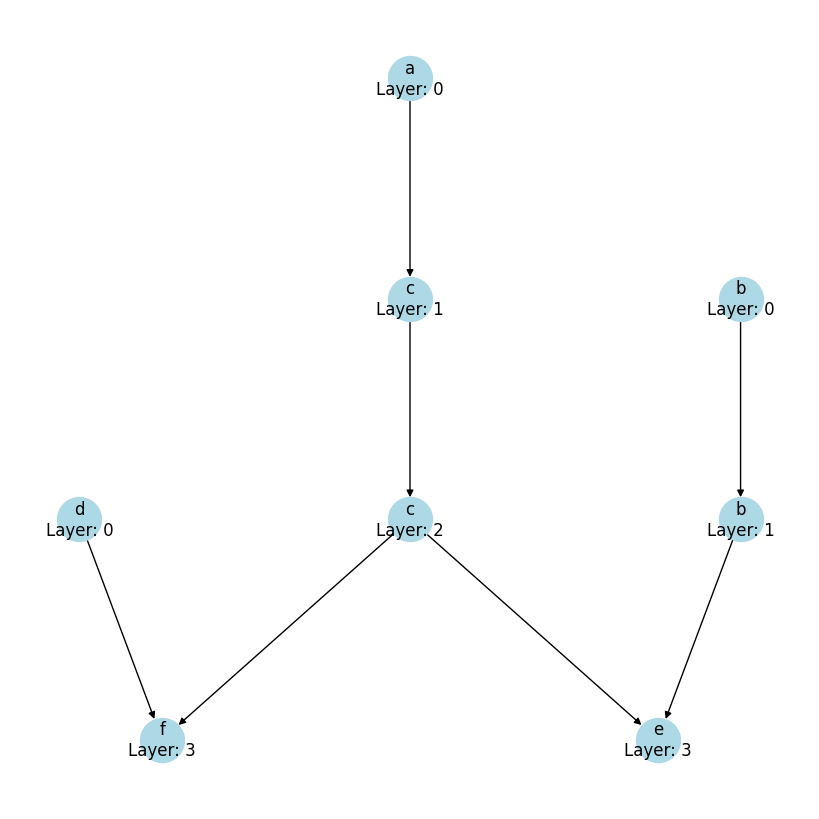

FNF([acdcfbbe]) = (adb)(cb)(c)(fe)


In [9]:
filepath="data/case1.txt"

current_dir = os.getcwd()
filename = os.path.join(current_dir, filepath)

alphabet, word, transaction = read_file(filename)
I, D = create_I_D(alphabet, transaction)

print("I = ", I)
print("D = ", D)

graph = make_graph(word)
plot_graph(graph)

printFNF(graph, word)

### Przykład `case2.txt`

I =  {('f', 'e'), ('e', 'f'), ('a', 'f'), ('f', 'a')}
D =  {('d', 'c'), ('e', 'd'), ('c', 'e'), ('e', 'a'), ('a', 'b'), ('c', 'f'), ('b', 'e'), ('e', 'c'), ('f', 'd'), ('c', 'b'), ('d', 'e'), ('b', 'f'), ('a', 'd'), ('d', 'f'), ('a', 'a'), ('b', 'b'), ('f', 'c'), ('c', 'd'), ('e', 'e'), ('d', 'b'), ('c', 'a'), ('a', 'c'), ('b', 'd'), ('c', 'c'), ('b', 'a'), ('d', 'd'), ('e', 'b'), ('d', 'a'), ('a', 'e'), ('f', 'f'), ('b', 'c'), ('f', 'b')}


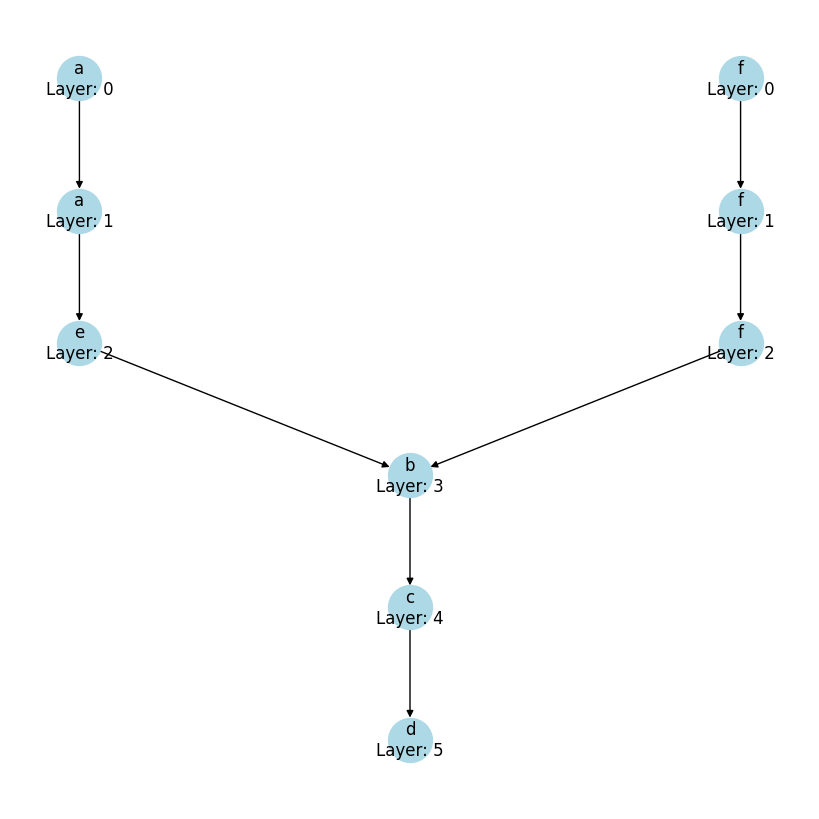

FNF([afaeffbcd]) = (af)(af)(ef)(b)(c)(d)


In [10]:
current_dir = os.getcwd()
filename = os.path.join(current_dir, "data/case2.txt")

alphabet, word, transaction = read_file(filename)
I, D = create_I_D(alphabet, transaction)

print("I = ", I)
print("D = ", D)

graph = make_graph(word)
plot_graph(graph)

printFNF(graph, word)